# Ordinary and Universal Kriging of CML rain rate data
- Install hdf5 package for reading HDF5 formatted CML data:
- Initial setup
- Declare functions
- Loop thru dates and call functions
    

### Initial setup

In [30]:
#source("https://bioconductor.org/biocLite.R")
#biocLite("rhdf5")

library(rhdf5)  # Library to read HDF5 formatted CML data
library(dplyr)
library(spdep)
library(gstat)    # library with krige functions
library(raster)
library(RColorBrewer)
library(maptools)
library(automap)
library(rgdal)

setwd('/home/micha/Studies/Courses/Geostatistics-Tal/Project/')
cml_file  <- "CML/cml_bavaria_v1.h5"
gauge_file  <- 'gauge_data/gauge_data_daily.csv'
gauge_meta_file <- 'gauge_data/gauge_metadata.csv'
# Load administrative boundaries for plotting
gadm_1 <- readRDS('GIS/DEU_adm1.rds')
cities <- shapefile('GIS/cities_de.shp')
# Filter out only Bavaria
cities <- subset(cities, cities$adm1_code==2)
# List of date strings

radar_dir <- '/home/micha/Studies/Research/IMAP/Data/DE/RADOLAN/daily/'

# Coordinate reference Systems
# Original data are in Long/Lat
# Transform to ETRS LAEA
proj_wgs84 = CRS("+init=epsg:4326")
proj_laea <- CRS("+init=epsg:3035")

# Function Definitions
- plot_map()
- slice_data()
- calculate_moran()
- prepare_variogram()
- prepare_krige_grid()
- perform_ok()
- OK_scatter()
- load_radar()
- perform_ked()
- KED_scatter()

In [31]:
# Plot initial map
plot_map <- function(cities, gadm_1, gauge_data, link_data) {
  # Clip gauges to region covered by links BBOX
  # first create spatial points data frame of links
 
  # Plot links and gauges
  #outpng <- 'Output/gauges_links_map.png'
  #png(outpng, width=800, height=600)
  plot(link_data, col="red", main="Bavaria - Links and Gauges",
       pch=18, cex=1.6)
  plot(gadm_1, border='black', add=T)
  points(gauge_data, col='blue', pch=7, cex=1.0)
  points(cities, pch=16, col='grey30', cex=1.2)
  pointLabel(coordinates(cities), cities$asciiname, cex=0.7)
  lclrs <- c('red','blue','grey30')
  lgnd <- c('CML Links','Gauges','Cities')
  legend('bottomright', col=lclrs, legend=lgnd, 
         lwd=2, cex=0.7, pch=c(18, 7, 16), lty=NA)
  scalebar(40000, type="bar", xy=c(4450000,2700000),
           divs=4, cex=0.7)
  #dev.off()
}

In [32]:
# Subset one day of data
# Function to slice out one day of data
slice_data <- function(link_data, gauge_data, datestr) {
  # Slice out link data for one day
  links_1day <- link_data[link_data$date_time == datestr,]
  # Remove all NaN values
  links_1day <- na.omit(links_1day)

  # Slice out gauge data for one day
  datestr_clean <- gsub("-","",datestr)
  gauges_1day <- gauge_data[gauge_data$date_time==datestr_clean,]
  # Crop out only the gauges that are in the links region
  gauges_1day <- crop(gauges_1day, extent(links_1day@bbox))
  
  retval <- list("gauges_1day"=gauges_1day, "links_1day"=links_1day)
  return(retval)
}

In [33]:
# ---------------------------------
# Check Point Pattern Dispersion
# Moran's I 
# ---------------------------------
# Function to calculate Moran's I, do Monte Carlo simulations and plot
calculate_moran <- function(links_1day, datestr) {
 
  # Weights matrix as inverse distances between all link points
  distances <- as.matrix(dist(as.data.frame(links_1day)))
  inv_dist = 1/distances
  diag(inv_dist) <- 0
  #print(inv_dist[1:5,1:5])
  wts <- mat2listw(inv_dist)
 
  # Moran's I
  Moran_I <- moran.test(links_1day$rain_rate, wts)
  print(Moran_I)
  I_stat <- Moran_I$estimate[1]
  I_expect <- Moran_I$estimate[2]
  
  # Monte Carlo simulations
  Moran_I_mc <- moran.mc(links_1day$rain_rate, wts, nsim=9999)
  # Get value of 1.96 Stdev of the Monte Carlo distribution
  sd2 <- 1.96 * sd(Moran_I_mc$res)
  

  # Create Histogram plot
  #png('Output/Morans_histogram.png', width=800, height=800)
  title <- paste("Moran's I - Dist. of Monte Carlo Simulations", datestr)
  hist(Moran_I_mc$res, xlab="Monte Carlo runs of Moran's I", 
       breaks=50, col="lightgrey", main=title)
  #mtext(datestr)
  abline(v=I_stat, col="red", lwd=3)
  abline(v=I_expect, col="orange", lwd=3)
  abline(v=sd2+I_expect, col="steelblue4", lwd=2, lty="dashed")
  abline(v=-sd2+I_expect, col="steelblue4", lwd=2, lty="dashed")
  lclrs <- c('red','orange','steelblue4')
  lgnd <- c('I statistic','Expected Value','2 Std Dev')
  legend('topright', col=lclrs, legend=lgnd, 
         lwd=2, cex=0.8)
  #dev.off()
  return(I_stat)
}

### Function to prepare and plot variogram

In [34]:
prepare_variogram <- function(links_1day, datestr) {
  vg <- variogram(rain_rate~1, data=links_1day)
  plot(vg)
  # Guess at range and sill
  vg_fit_man <- fit.variogram(vg, 
                              vgm(psill=0.5,c('Exp','Sph','Gau'),range=20000))
    
  vg_fit_auto <- autofitVariogram(rain_rate~1, 
                             input_data=links_1day,
                             model=c("Exp","Sph","Gau"),
                             verbose=TRUE)

  #outpng <- paste0("Output/variogram_", datestr, ".png")
  #png(outpng, width=600, height=400)
  y_upper <- max(vg$gamma)*1.1
  x_upper <- max(vg$dist)*1.1
  title <- paste("Variogram_",datestr)
  plot(gamma~dist, vg, col="blue", main=title,
       xlab="Distance", ylab="Semivariance", 
       ylim=c(0, y_upper), xlim=c(0,x_upper))
  lines(variogramLine(vg_fit_man, x_upper), col="red")
  lines(variogramLine(vg_fit_auto$var_model, x_upper), col="green", lwd=2, lty=3)

  lclrs <- c('red','green')
  lgnd <- c('Manual fit','Auto')
  legend('bottomright', col=lclrs, legend=lgnd, lwd=2, lty=c(1,4,1,2), cex=0.8)
  #dev.off()
  
  # Return the fitted model 
  return(vg_fit_man)
}

### Prepare output grid

In [35]:
prepare_krige_grid <- function(link_data) {
  # Setup grid for output raster, resolution 1000 m.
  # links_1day is already tranformed to LAEA, 
  # be sure to use @coords (NOT lon, lat columns)
  # Extend grid 6000 m. beyond the links region (6 pixels)
  mnx <- min(link_data@coords[,1])-6000
  mxx <- max(link_data@coords[,1])+6000
  mny <- min(link_data@coords[,2])-6000
  mxy <- max(link_data@coords[,2])+6000
  grd <- expand.grid(lon=seq(mnx,mxx,1000), lat=seq(mny,mxy,1000))
  xy_coords <- cbind(grd$lon, grd$lat)
  coordinates(grd) <- xy_coords
  proj4string(grd) <- proj_laea
  gridded(grd) <- TRUE
  return(grd)
}

### Function to perform Ordinary Kriging

In [36]:
perform_ok <- function(links_1day, vg_fit, gauges_1day, grd, datestr) {
 
  # First: Remove duplicated locations!
    zdist <- zerodist(links_1day)[,1]
    if (length(zdist)>0) {
        # Remove rows identified by zerodist
    links_1day <- links_1day[-zdist,]
      }
  
  # === Kriging on grid ===
    OK_grid <- krige(rain_rate~1, 
                    locations=links_1day, newdata=grd, model=vg_fit)
  
  # Plot krige raster
    clrs <- brewer.pal(8,'BuPu')
    title <- paste("Ordinary Kriging Interpolation ", datestr)
    #outpng <- paste0("Output/OK_interp_", links_1day$date_time[1], ".png")
    #png(outpng, width=800, height=600)
    plot(OK_grid, col=clrs, main=title)
    plot(links_1day, col="red", pch=18, cex=1.2, add=T)
    plot(gadm_1, border='black', lwd=1, add=T)
    #dev.off()
  
  # === Kriging at gauge locations ===
    OK_gauges <- krige(rain_rate~1, 
                           locations=links_1day, newdata=gauges_1day, model=vg_fit)
  
  # Join results with gauges to get the station_id, and observed precip 
    gauges_obs <- data.frame("station_id"=gauges_1day$station_id, 
                           "obs_precip"=gauges_1day$obs_precip,
                          "x_coord"=gauges_1day@coords[,1], 
                          "y_coord"=gauges_1day@coords[,2])
    links_pred <- data.frame("pred"=OK_gauges$var1.pred,
                           "x_coord"=OK_gauges@coords[,1], 
                           "y_coord"=OK_gauges@coords[,2])
    OK_results <- merge(gauges_obs, links_pred, by=c('x_coord', 'y_coord'))

  return(OK_results)
}

In [37]:
OK_scatter <- function(OK_results) {
    corrcoef <- cor(OK_results$pred, OK_results$obs_precip)
    print(paste("Correlation Coefficient Gauge Observations vs OK: ", corrcoef))

    #outpng <- paste0("Output/OK_Scatter_", links_1day$date_time[1], ".png")
    title <- paste("OK vs Observed Precipitation ", datestr)
    #png(outpng, width=800, height=600)
    plot(OK_results$pred~OK_results$obs_precip, main=title, 
       xlab="Observed", ylab="OK prediction", pch=16, col="blue")
    abline(lm(OK_results$pred~OK_results$obs_precip), col="red")
    legend("topleft", paste("Correlation: ", round(corrcoef,3)),
          cex=0.9, bty="n")
    #dev.off()
}

 ## Kriging with External Drift

1. use radar raster as external independant variable
2. First: Remove duplicated locations!
3. Prepare new variogram and model with independant variables
4. Add to the grd object an attibute column 
    for the independant variable "radar_precip"
5. KED on grid
6. KED at gauge locations

In [38]:
load_radar <- function(datestr,grd) {
    # Get the radar raster (AAI grid), reproject and clip to links region
    radar_file <- paste0(radar_dir,'rw_',gsub('-','',datestr), '.asc')
    print(paste("Loading RADOLAN file:", radar_file))
    radar <- raster(radar_file)
    radar <- projectRaster(radar, res=1000, crs=proj_laea)
    radar <- crop(radar, grd@bbox)
  
    # Plot radar
    #outpng <- paste0("Output/Radar_", links_1day$date_time[1], ".png")
    title <- paste("Radar rain rate ", datestr)
    #png(outpng, width=800, height=600)
    clrs <- brewer.pal(8,'YlGnBu')
    plot(radar, col=clrs, main=title)
    plot(links_1day, col="red", pch=18, cex=0.8, add=T)
    plot(gadm_1, border='black', lwd=1, add=T)
    #dev.off()

    return(radar)   
}

### Functions to perform Universal Kriging

In [39]:
perform_ked <- function(links_1day, gauges_1day, radar, grd, datestr) {
    # Make sure no duplicates
  zdist <- zerodist(links_1day)[,1]
  if (length(zdist)>0) {
    # Remove rows identified by zerodist
    links_1day <- links_1day[-zdist,]
  }
    # New variogram, using the independant variable
  links_1day$radar_precip <- extract(radar, links_1day)
  vg2 <- variogram(rain_rate~radar_precip, data=links_1day)
  vg2_fit <- fit.variogram(vg2, 
                          vgm(psill=0.5,c('Exp','Sph','Gau'),range=20000))
    
    # === Kriging on grid ===
  grd$radar_precip <- 0.0
  KED_grid <- krige(rain_rate ~ radar_precip, 
                    links_1day, grd, model=vg2_fit)
    # Plot KED 
  clrs <- brewer.pal(8,'BuPu')
  #outpng <- paste0("Output/KED_interp_", links_1day$date_time[1], ".png")
  title <- paste("Kriging with External Drift Interpolation ", datestr)
  #png(outpng, width=800, height=600)
  plot(KED_grid, col=clrs, main=title)
  plot(links_1day, col="red", pch=18, cex=1.2, add=T)
  plot(gadm_1, border='black', lwd=1, add=T)
  #dev.off()

  # ===  Kriging at gauge locations ===
  # Add attribute column "radar_precip"  to the gauges SPDF
  gauges_1day$radar_precip <- 0.0
  KED_gauges <- krige(rain_rate ~ radar_precip, 
                      links_1day, gauges_1day, model=vg_fit)
  
  # Join results with gauges to get the station_id, and observed precip 
  gauges_obs <- data.frame("station_id"=gauges_1day$station_id, 
                           "obs_precip"=gauges_1day$obs_precip,
                          "x_coord"=gauges_1day@coords[,1], 
                          "y_coord"=gauges_1day@coords[,2])
  links_pred <- data.frame("pred"=KED_gauges$var1.pred,
                           "x_coord"=KED_gauges@coords[,1], 
                           "y_coord"=KED_gauges@coords[,2])
  KED_results <- merge(gauges_obs, links_pred, by=c('x_coord', 'y_coord'))

  return(KED_results)
}

In [40]:
KED_scatter <- function(KED_results, datestr) {
    
    # Plot KED versus gauges
    corrcoef <- cor(KED_results$pred, KED_results$obs_precip)
    print(paste("Correlation Coefficient Gauge Observations vs KED: ", corrcoef))
    title <- paste("KED vs Observed Precipitation", datestr)

    outpng <- paste0("Output/KED_Scatter_", datestr, ".png")
    #png(outpng, width=800, height=600)
    plot(KED_results$pred ~ KED_results$obs_precip, 
            main=title, 
            xlab="Observed", ylab="KED prediction", pch=16, col="blue")
    abline(lm(KED_results$pred ~ KED_results$obs_precip), col="red")
    legend("topleft", paste("Correlation: ", round(corrcoef,3)),
          cex=0.9, bty="n")
    #dev.off()
}

In [58]:
gauge_radar_scatter <- function(gauges_1day, radar, datestr) {
    # Second scatterplot comparing gauge observations with radar values
    gauges_1day$radar_precip <- extract(radar, gauges_1day)
    corrcoef <- cor(gauges_1day$obs_precip, gauges_1day$radar_precip)
    print(paste("Correlation Coefficient Gauge Observations vs Radar: ", corrcoef))
    
    outpng <- paste0("Output/Gauge_Radar_Scatter_", datestr, ".png")
    #png(outpng, width=800, height=600)
    title <- paste("Radar vs Observed Precipitation", datestr)
    plot(gauges_1day$obs_precip, gauges_1day$radar_precip, 
            main=title, 
            xlab="Observed", ylab="Radar precip", pch=16, col="blue")
    abline(lm(gauges_1day$obs_precip ~ gauges_1day$radar_precip), col="red")
    legend("topleft", paste("Correlation: ", round(corrcoef,3)), 
           cex=0.9, bty="n")
    #dev.off() 
    
}

### end of function definitions

# Begin Process
### Load CML data

In [59]:
# Open HDF5 file of CML data, and get list of links (groups in HDF5)
grp_list <- filter(h5ls(cml_file), grepl("product_0", name))
dt_col <- rep('time', length(grp_list$group))
rr_col <- rep('rain rate', length(grp_list$group))
dt_list <- paste(grp_list$group, grp_list$name, dt_col, sep="/")
rr_list <- paste(grp_list$group, grp_list$name, rr_col, sep="/")

num_links <- length(rr_list)
link_data <- list()
link_meta <- list()

### Loop thru all CML links, 
### get meta_data and rain rate data for each 

In [60]:
for (i in 1:num_links) {
  rr_dset <- h5read(cml_file, rr_list[i])
  dt_dset <- h5read(cml_file, dt_list[i])
  attrs <- h5readAttributes(cml_file, grp_list[i,]$group)
  # Create list of metadata for all cmls
  link_id <- attrs$cml_id
  # Set link point at *middle* between antennas
  lat <- (attrs$site_a_latitude + attrs$site_b_latitude)/2
  lon <- (attrs$site_a_longitude + attrs$site_b_longitude)/2
  meta <- data.frame(link_id, lon, lat)
  colnames(meta) <- c('link_id','lon','lat')
  link_meta[[i]] <- meta 
  
  # Make a list of all daily data for this cml
  dset <- as.data.frame(cbind(rr_dset, dt_dset))
  colnames(dset) <- c('rain_rate', 'date_time')
  dset$date_time <- as.POSIXct(dset$date_time, 
                               origin="1970-01-01", tz='GMT')
  cml_daily <- dset %>% 
    group_by(date_time = cut(date_time, breaks="1 day")) %>%
    summarize(rain_rate = mean(rain_rate)*24)
  
  link_id_list <- rep(link_id, length(cml_daily$date_time))
  cml_daily['link_id'] <- link_id_list
  link_data[[i]] <-  cml_daily
} 

In [61]:
# Convert lists to DF
link_meta <- do.call(rbind, link_meta)
link_data <- do.call(rbind, link_data)
link_data <- as.data.frame(link_data)
link_data <- merge(link_data, link_meta, all.x=FALSE)
link_data <- na.omit(link_data)

H5close()
print(paste("Found: ",length(link_meta$link_id), "links"))
print(paste("Aggregated: ", length(link_data$link_id),
            "rows of daily CML data"))

[1] "Found:  217 links"
[1] "Aggregated:  8715 rows of daily CML data"


### Load gauge data

In [62]:
# Read CSV files of gauge data and metadata 
data_cols <- c('station_id','date_time','quality',
               'obs_precip', 'precip_ind','snow','eor')
gauge_data <- read.csv(gauge_file, col.names=data_cols)
meta_cols <- c('station_id','from_date','to_date','elevation',
               'latitude','longitude',
               'stn_name','province')
gauge_meta <- read.csv(gauge_meta_file, col.names=meta_cols)

# Join spatial data with gauge data
gauge_data <- merge(gauge_data, gauge_meta, 
                    by='station_id', all.x=FALSE)
# Make sure to clean out NA or < 0 (unknown values)
gauge_data <- na.omit(gauge_data)
gauge_data <- filter(gauge_data, obs_precip>=0)
print(paste("Found: ",length(gauge_meta$station_id), "gauges"))
print(paste("Found: ", length(gauge_data$station_id),
            "rows of daily gauge data"))

[1] "Found:  1139 gauges"
[1] "Found:  147662 rows of daily gauge data"


### Make SPDF from data frames

In [63]:
# First SpatialPointsDataFrame from the Link data
link_coords <- cbind(link_data$lon, link_data$lat)
coordinates(link_data) <- link_coords
proj4string(link_data) <- proj_wgs84
links_bbox <- link_data@bbox

# also spatial points data frame of gauges
gauge_coords <- cbind(gauge_data$longitude, gauge_data$latitude)
coordinates(gauge_data) <- gauge_coords
proj4string(gauge_data) <- proj_wgs84
# and crop to links BBOX
gauge_data <- crop(gauge_data, extent(links_bbox))

# Transform all spatial data to European LAEA projection, EPSG:3035
cities <- spTransform(cities, proj_laea)
gadm_1 <- spTransform(gadm_1, proj_laea)
gauge_data <- spTransform(gauge_data, proj_laea)
link_data <- spTransform(link_data, proj_laea)

### Plot initial map

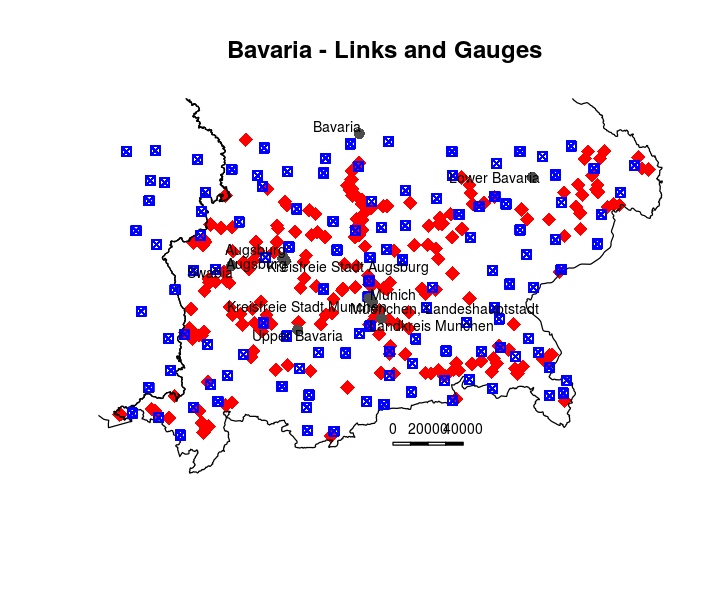

In [64]:
options(repr.plot.width=6, repr.plot.height=5)
plot_map(cities, gadm_1, gauge_data, link_data)

### Setup grid for kriging results

In [65]:
grd <- prepare_krige_grid(link_data)

### Begin process - one day

In [66]:
datestrs = c('2016-07-01', '2016-07-02',
             '2016-07-03', '2016-07-04',
             '2016-07-05', '2016-07-06',
             '2016-07-07', '2016-07-08',
             '2016-07-09', '2016-07-10',
             '2016-07-11', '2016-07-12',
             '2016-07-13', '2016-07-14',
             '2016-07-15', '2016-07-16',
             '2016-07-17', '2016-07-18',
             '2016-07-19', '2016-07-20')

datestr = datestrs[12]
  # Extract data for one day
data_1day <- slice_data(link_data, gauge_data, datestr)
links_1day <- data_1day$links_1day
gauges_1day <- data_1day$gauges_1day

Warning message in dist(as.data.frame(links_1day)):
“NAs introduced by coercion”


	Moran I test under randomisation

data:  links_1day$rain_rate  
weights: wts  

Moran I statistic standard deviate = 7.2033, p-value = 2.939e-13
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.1901108528     -0.0100000000      0.0007717553 



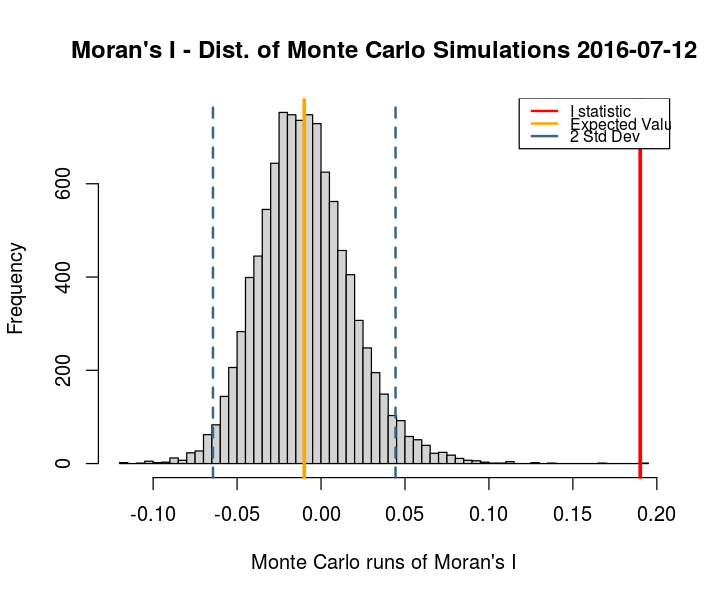

In [67]:
# Moran's I for autocorrelation
Moran_I <- calculate_moran(links_1day, datestr)

### Create a variogram and fitted model

Checking if any bins have less than 5 points, merging bins when necessary...

Selected:
  model     psill    range
1   Nug  24.97104     0.00
2   Exp 179.91280 42155.68

Tested models, best first:
  Tested.models kappa      SSerror
1           Exp     0 0.0007423258
2           Sph     0 0.0009701525
3           Gau     0 0.0016527564


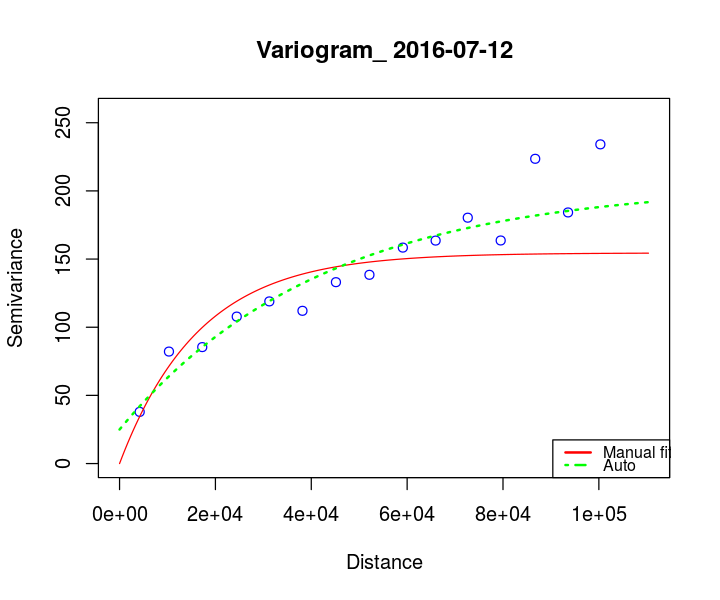

In [68]:
vg_fit <- prepare_variogram(links_1day, datestr)  

### Do Ordinary Kriging

[using ordinary kriging]
[using ordinary kriging]


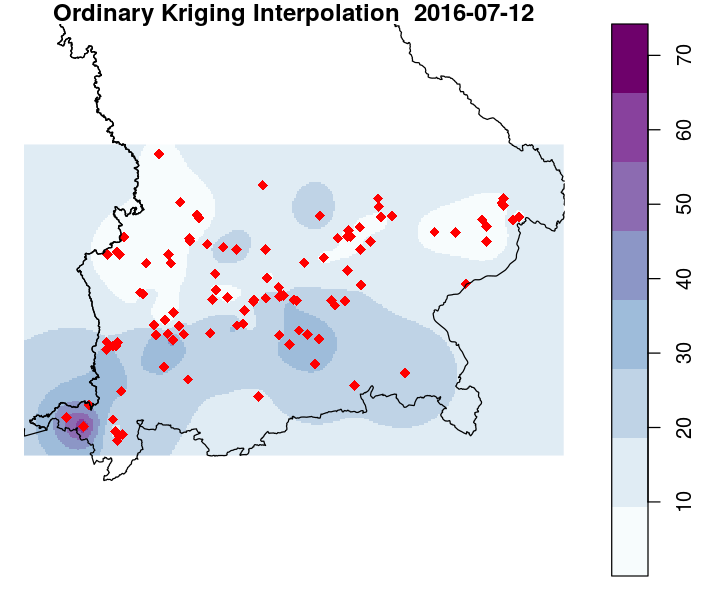

In [69]:
OK_results <- perform_ok(links_1day, vg_fit, gauges_1day, grd, datestr)

### Scatterplot of gauge data vs. krige predictions

[1] "Correlation Coefficient Gauge Observations vs OK:  0.648693864240518"


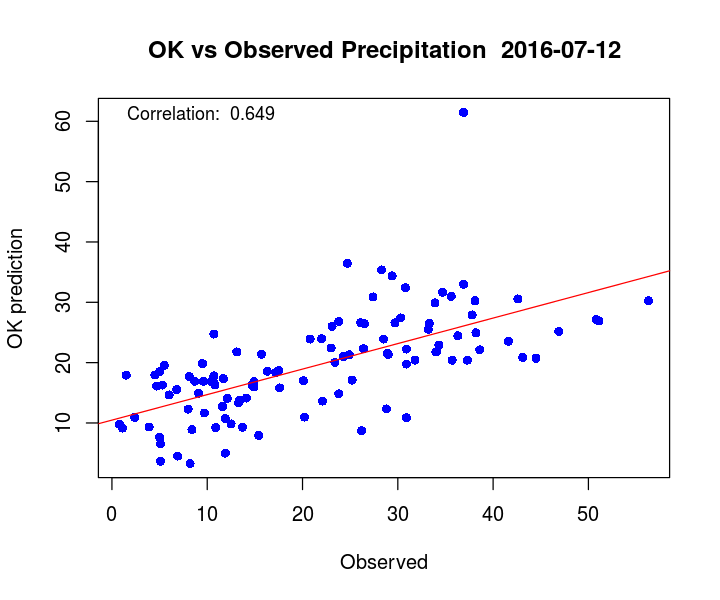

In [70]:
OK_scatter(OK_results)

### Load and plot radar data

[1] "Loading RADOLAN file: /home/micha/Studies/Research/IMAP/Data/DE/RADOLAN/daily/rw_20160712.asc"


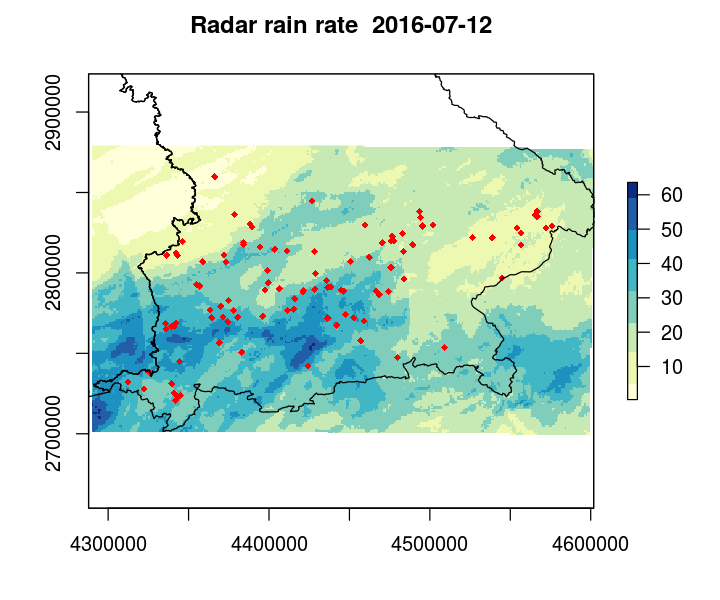

In [71]:
# Plot radar
radar <- load_radar(datestr, grd)

### Do Kriging with External Drift

[using universal kriging]
[using universal kriging]


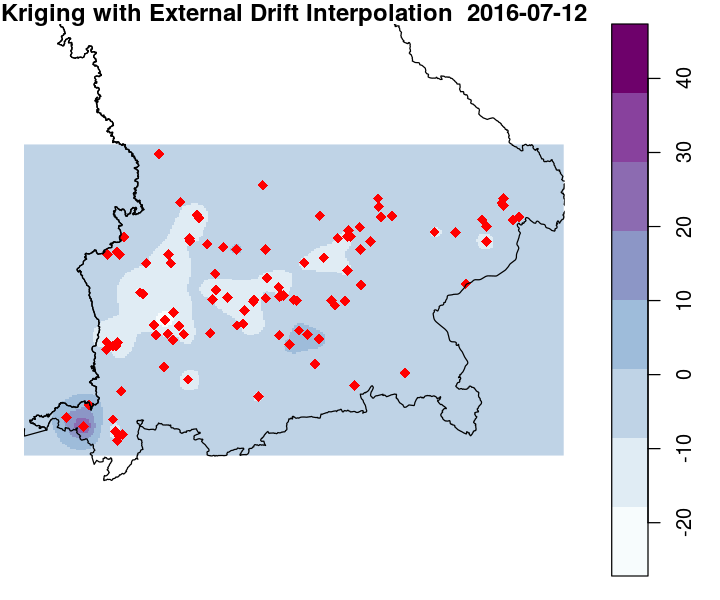

In [72]:
KED_results <- perform_ked(links_1day, gauges_1day, radar, grd, datestr)

### Scatterplot of gauge data vs. krige predictions

[1] "Correlation Coefficient Gauge Observations vs KED:  0.226348277467327"


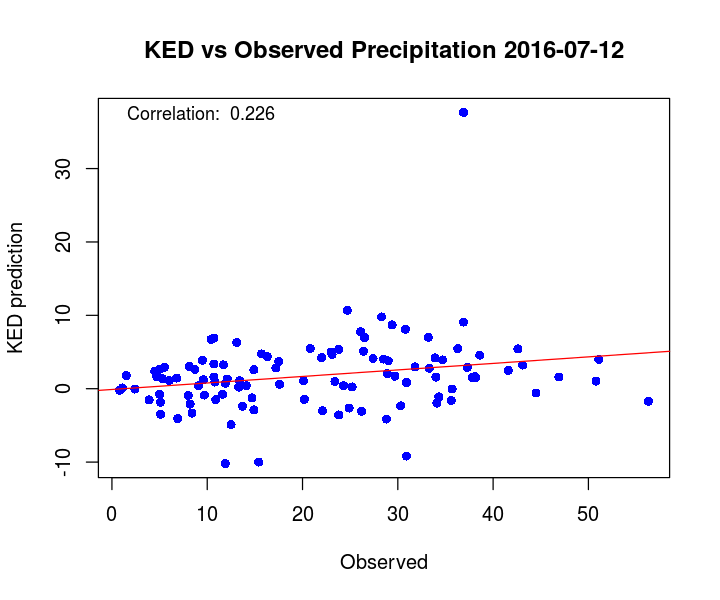

In [73]:
KED_scatter(KED_results)

### Scatterplot of gauge data vs. radar

[1] "Correlation Coefficient Gauge Observations vs Radar:  0.879279072589415"


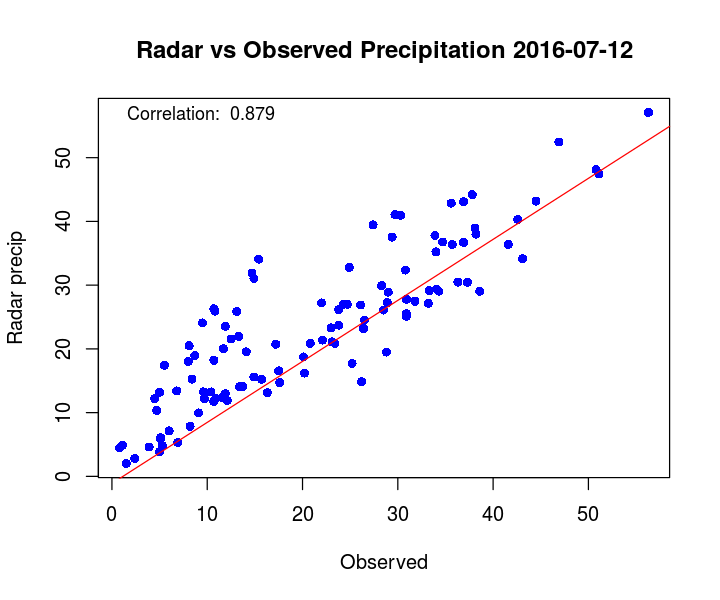

In [74]:
gauge_radar_scatter(gauges_1day, radar, datestr)